In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import os
import random
import pickle
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import rnn
from main import *

In [6]:
data = load_data("../data/GM12878_10k", "../data/loop_sequences_GM12878.fasta", "../data/epigenomic_tracks/GM12878.pickle")
#X, ranges = generate_X(data[:500])

Reading histone data...
Reading sequence data...
Reading Hi-C data...
Loaded 4280 items - 17 had missing data.


In [54]:
def evaluate_consistency(mat, states, resolution, num_states):
    """
    Returns a measure of consistency of the given state mapping with respect to the interaction matrix.
    mat - an InteractionMatrix object
    states - a state labeling over the sequence of the given matrix
    resolution - the resolution of the given state labeling (i.e. number of base pairs labeled per element of states)
    num_states - the number of states possible
    """
    # Collect interaction frequencies
    interaction_frequencies = [[[] for i in range(num_states)] for j in range(num_states)]
    start, end = mat.range()
    _, num_data_points = mat.coordinates_grid(resolution)
    #print(len(states), "vs", num_data_points)
    values = np.log(1 + mat.values_grid(resolution))
    
    # Group interaction frequencies by which pair of states were assigned to x and y
    for i, state in enumerate(states):
        if i >= num_data_points: break
        for j, other_state in enumerate(states):
            if j >= num_data_points: break
            interaction_frequencies[state][other_state].append(values[i][j])
            
    # Get mean and standard dev
    #means = np.array([[np.mean(interaction_frequencies[i][j]) for i in range(num_states)] for j in range(num_states)])
    stds = np.array([[np.std(interaction_frequencies[i][j]) for i in range(num_states)] for j in range(num_states)]).flatten()
    stds = stds[np.isfinite(stds)]
    #print(means, stds)
    return np.mean(stds)

In [35]:
seq, mat = data[2]
resolution = 100
num_states = 2
states = np.concatenate([np.zeros(1800), np.ones(1100)]).astype(int) #np.random.randint(0, num_states, size=len(seq.seq) // resolution)
print(evaluate_consistency(mat, states, resolution, num_states))

2900 vs 2901
[[5.439311   4.34455721]
 [4.34141802 5.92317897]] [[0.76547956 0.4072147 ]
 [0.4064359  0.76166589]]
0.585199014757005


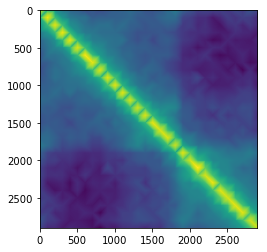

In [33]:
plt.imshow(np.log(1 + mat.values_grid(resolution)))

In [49]:
# Generate an X matrix for RNN training
random_loops = [data[i] for i in random.sample(range(len(data)), 50)]
X, ranges = generate_X(random_loops, spacing=resolution)

In [50]:
Y_numerical = np.random.randint(0, num_states, size=X.shape[0])
Y = np.zeros((X.shape[0], num_states))
for i in range(Y_numerical.shape[0]):
    Y[i,Y_numerical[i]] = 1
print(X.shape, Y.shape)

(84800, 9, 100) (84800, 2)


In [57]:
consistencies = np.zeros((4, 4))
for i, rec_nodes in enumerate([1, 5, 10, 20]):
    for j, dense_nodes in enumerate([5, 10, 20, 50]):
        print(rec_nodes, dense_nodes)
        model = rnn.RNNModel(recurrent_nodes=[rec_nodes], dense_nodes=[dense_nodes, dense_nodes], 
                            n_labels=num_states, n_features=X.shape[1], sequence_length=X.shape[2])
        model.create()
        model.train(X, Y, epochs=5)
        Y_pred = np.argmax(model.model.predict(X), axis=1)
        my_consistencies = [evaluate_consistency(data[k][1], Y_pred[start:end], resolution, num_states) for k, (start, end) in enumerate(ranges)]
        consistencies[i, j] = sum(my_consistencies) / len(my_consistencies)

1 5
Epoch 1/5
84800/84800 [==============================] - 15s 178us/step - loss: 0.6932 - acc: 0.4987
Epoch 2/5
84800/84800 [==============================] - 14s 160us/step - loss: 0.6932 - acc: 0.5013
Epoch 3/5
84800/84800 [==============================] - 13s 154us/step - loss: 0.6932 - acc: 0.4990
Epoch 4/5
84800/84800 [==============================] - 13s 154us/step - loss: 0.6932 - acc: 0.5015
Epoch 5/5
84800/84800 [==============================] - 14s 163us/step - loss: 0.6932 - acc: 0.5008


/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 10
Epoch 1/5
84800/84800 [==============================] - 15s 180us/step - loss: 0.6932 - acc: 0.5018
Epoch 2/5
84800/84800 [==============================] - 13s 157us/step - loss: 0.6932 - acc: 0.5036
Epoch 3/5
84800/84800 [==============================] - 13s 154us/step - loss: 0.6932 - acc: 0.4995
Epoch 4/5
84800/84800 [==============================] - 13s 154us/step - loss: 0.6932 - acc: 0.4992
Epoch 5/5
84800/84800 [==============================] - 13s 156us/step - loss: 0.6931 - acc: 0.5016
1 20
Epoch 1/5
84800/84800 [==============================] - 15s 176us/step - loss: 0.6932 - acc: 0.5015
Epoch 2/5
84800/84800 [==============================] - 13s 158us/step - loss: 0.6932 - acc: 0.5004
Epoch 3/5
84800/84800 [==============================] - 13s 157us/step - loss: 0.6932 - acc: 0.5013
Epoch 4/5
84800/84800 [==============================] - 13s 158us/step - loss: 0.6932 - acc: 0.4991
Epoch 5/5
84800/84800 [==============================] - 14s 168us/step - loss: 0

In [55]:
for k, (start, end) in enumerate(ranges):
    print(k, start, end, Y_pred[start:end])
    print(evaluate_consistency(data[k][1], Y_pred[start:end], resolution, num_states))

0 0 1700 [1 1 1 ... 1 1 1]


/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8772949944031979
1 1700 3250 [1 1 1 ... 1 1 1]
0.8033859234584692
2 3250 5850 [1 1 1 ... 1 1 1]
0.8917538371070707
3 5850 8750 [1 1 1 ... 1 1 1]
0.7537994492364052
4 8750 9950 [1 1 1 ... 1 1 1]
0.7006715079203912
5 9950 11950 [1 1 1 ... 1 1 1]
0.7979816852602369
6 11950 13950 [1 1 1 ... 1 1 1]
0.6835314127523899
7 13950 16500 [1 1 1 ... 1 1 1]
0.7913265690011416
8 16500 18650 [1 1 1 ... 1 1 1]
0.7305117214710528
9 18650 20450 [1 1 1 ... 1 1 1]
0.8707701488418815
10 20450 21400 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

KeyboardInterrupt: 

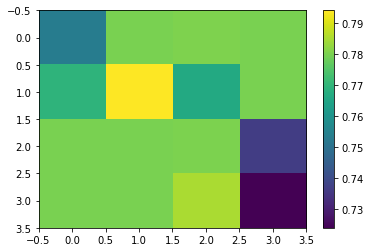

In [59]:
plt.imshow(consistencies, aspect='auto')
plt.colorbar()